<a href="https://colab.research.google.com/github/Crliu4/supreme_court_verdict_predictor/blob/main/Data_Cleaning_%26_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Supreme Court Verdict Predictor 
### Maggie Chen, Carolyn Liu, Eujene Yum

In [ ]:
!export LC_ALL=en_US.UTF-8 && pip install scikit-learn==1.1.3
!pip install convokit
from convokit import Corpus, download, util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.0/168.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for convokit: filename=convokit-2.5.3-py3-n

In [ ]:
corpus_2019 = Corpus(filename=download("supreme-2019"))
corpus_2018 = Corpus(filename=download("supreme-2018"))
corpus_2017 = Corpus(filename=download("supreme-2017"))
corpus_2016 = Corpus(filename=download("supreme-2016"))
corpus_2015 = Corpus(filename=download("supreme-2015"))
corpus_2014 = Corpus(filename=download("supreme-2014"))
corpus_2013 = Corpus(filename=download("supreme-2013"))
corpus_2012 = Corpus(filename=download("supreme-2012"))
corpus_2011 = Corpus(filename=download("supreme-2011"))
corpus_2010 = Corpus(filename=download("supreme-2010"))

## Data Overview

In [ ]:
corpus_list = [corpus_2010, corpus_2011, corpus_2012, corpus_2013, corpus_2014, corpus_2015, corpus_2016, corpus_2017, corpus_2018, corpus_2019]

for i, corpus in enumerate(corpus_list):
  print('Year {}'.format(i + 2010))
  print(corpus.print_summary_stats())
  print("-------")


Year 2010
Number of Speakers: 150
Number of Utterances: 17138
Number of Conversations: 78
None
-------
Year 2011
Number of Speakers: 127
Number of Utterances: 16388
Number of Conversations: 73
None
-------
Year 2012
Number of Speakers: 127
Number of Utterances: 16606
Number of Conversations: 74
None
-------
Year 2013
Number of Speakers: 118
Number of Utterances: 14556
Number of Conversations: 67
None
-------
Year 2014
Number of Speakers: 97
Number of Utterances: 12182
Number of Conversations: 55
None
-------
Year 2015
Number of Speakers: 127
Number of Utterances: 15986
Number of Conversations: 69
None
-------
Year 2016
Number of Speakers: 110
Number of Utterances: 13060
Number of Conversations: 62
None
-------
Year 2017
Number of Speakers: 124
Number of Utterances: 15703
Number of Conversations: 65
None
-------
Year 2018
Number of Speakers: 133
Number of Utterances: 16600
Number of Conversations: 71
None
-------
Year 2019
Number of Speakers: 113
Number of Utterances: 13707
Number of Co

In [ ]:
!pip install imbalanced-learn

In [ ]:
# Imports
from imblearn.over_sampling import RandomOverSampler, SMOTE
# from convokit import model, util
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import xgboost as xgb
import lightgbm as lgb

---

## Preprocessing

In [ ]:
# concatenate utterances over 5 years into a single df
frames = []
for corpus in corpus_list:
  frames.append(model.conversation.Conversation.get_utterances_dataframe(corpus))

utts = pd.concat(frames)

In [ ]:
# append conv win rate 
frames = []
for corpus in corpus_list:
  frames.append(model.corpus.Corpus.get_conversations_dataframe(corpus))

conv_df = pd.concat(frames)
conv_df.reset_index(inplace = True)

In [ ]:
# code for one of the bar graphs in poster 
merged_df = utts.merge(conv_df, left_on='conversation_id', right_on='id')
merged_df['year'] = merged_df['meta.case_id_x'].str[:4]
test = merged_df[['year','meta.win_side', 'conversation_id']]
test = test.drop_duplicates()
df1 = pd.get_dummies(test, columns=['meta.win_side'])
df2 = df1.groupby(['year']).agg('sum')
df2.reset_index(inplace=True)

p = df2['meta.win_side_1']
r = df2['meta.win_side_0']
labels = list(df2['year'].unique())
x = df2['year'].astype(int)
fig, ax = plt.subplots()
width=0.30
rects1 = ax.bar(x-width/2, r, width, label='Petitioner Loss')
rects2 = ax.bar(x+width/2, p, width, label='Petitioner Win')
ax.set_xlabel('Year')
ax.set_xticks(x, labels)
ax.set_title('Distribution of Case Outcomes by Year')
ax.set_ylim(0, 60)
ax.legend()
ax.bar_label(rects1, padding=2, fmt='%.0f')
ax.bar_label(rects2, padding=2, fmt='%.0f')
fig.tight_layout()
plt.savefig(PATH + 'target_by_year.png', bbox_inches='tight')
plt.show()

In [ ]:
merged_df = utts.merge(conv_df, left_on='conversation_id', right_on='id')
final_df = merged_df[['conversation_id', 'text', 'meta.speaker_type', 'meta.side', 'meta.win_side']]

In [ ]:
final_df = final_df[(final_df['meta.win_side'] == 1) | (final_df['meta.win_side'] == 0)]
final_df.shape

(150715, 5)

In [ ]:
# final def is at the utterance level
final_df['meta.side'] = final_df['meta.side'].fillna(-1) 

# filter out only None/0/1 for meta.side
final_df = final_df[(final_df["meta.side"] != 2) & (final_df["meta.side"] != 3)]

In [ ]:
final_df['meta.side'].unique()

array([-1,  1,  0])

In [ ]:
# concatenate texts for each conversation_id (under the same speaker_type)
df = final_df.copy()
df['text'] = df[['conversation_id', 'text', 'meta.speaker_type', 'meta.side','meta.win_side']].groupby(['conversation_id','meta.speaker_type', 'meta.side'])['text'].transform(lambda x: ','.join(x))
df = df[['conversation_id', 'text', 'meta.speaker_type', 'meta.side', 'meta.win_side']].drop_duplicates()
df = df.dropna()
df.head(5) # 0 is for respondent, 1 for petitioner, -1 for judge

,conversation_id,text,meta.speaker_type,meta.side,meta.win_side
0,22372,"We will hear argument next in Case 09-479, Abb...",J,-1,0
1,22372,"Mr. Chief Justice, and may it please the Court...",A,1,0
91,22372,"Mr. Chief Justice, and may it please the Court...",A,0,0
197,21694,"We'll hear argument today in Case 10-174, Amer...",J,-1,1
198,21694,Mr. Chief Justice and may it please the Court:...,A,1,1


### Including text cleaning, i.e. stop words, keep only stems!

In [ ]:
# get rid of stop words
nltk.download('stopwords')
stop = stopwords.words('english')

df = df[df['text'].notnull()]
df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split(" ") if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["unstemmed"] = df["cleaned_text"].str.split()

In [ ]:
# only keep stem
stemmer = SnowballStemmer("english")
df["stemmed"] = df["unstemmed"].apply(lambda x : [stemmer.stem(y) for y in x])

In [ ]:
df.head(3)

,conversation_id,text,meta.speaker_type,meta.side,meta.win_side,cleaned_text,unstemmed,stemmed
0,22372,"We will hear argument next in Case 09-479, Abb...",J,-1,0,"We hear argument next Case 09-479, Abbott v. U...","[We, hear, argument, next, Case, 09-479,, Abbo...","[we, hear, argument, next, case, 09-479,, abbo..."
1,22372,"Mr. Chief Justice, and may it please the Court...",A,1,0,"Mr. Chief Justice, may please Court:\nThe stat...","[Mr., Chief, Justice,, may, please, Court:, Th...","[mr., chief, justice,, may, pleas, court:, the..."
91,22372,"Mr. Chief Justice, and may it please the Court...",A,0,0,"Mr. Chief Justice, may please Court:\nA distri...","[Mr., Chief, Justice,, may, please, Court:, A,...","[mr., chief, justice,, may, pleas, court:, a, ..."


In [ ]:
df["finally_cleaned"] = df["stemmed"].apply(lambda x : " ".join(x))

#### Write to csv so we can read that in for future

In [ ]:
df.to_csv('sc_conv_level.csv')

------------

## Start here when we have already preprocessed data!

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

# Carolyn's path
PATH = "gdrive/MyDrive/"

# Eujene's path
# PATH = "gdrive/MyDrive/Colab Notebooks/datasets/" #to be changed later

# Maggie's path
# PATH = "gdrive/MyDrive/Colab Notebooks/datasets/"

Mounted at /content/gdrive


In [ ]:
# import csv
df = pd.read_csv(PATH + 'sc_conv_level.csv')
df.drop(columns = ["Unnamed: 0"], inplace = True)

In [ ]:
# groupby conv id and concat finally cleaned text
df_nn = df.groupby(['conversation_id'])['finally_cleaned'].apply(','.join).reset_index()

In [ ]:
# get win side
df_nn1 = df_nn.merge(df[['conversation_id', 'meta.win_side']], on='conversation_id')
df_nn1.drop_duplicates(inplace=True)
df_nn1.reset_index(inplace=True)

In [ ]:
# Check class imbalance
df_nn1['meta.win_side'].value_counts()

1    425
0    242
Name: meta.win_side, dtype: int64

### Oversample minority class, train test split, create dataloaders for neural network model


In [ ]:
lst = df_nn1['finally_cleaned'].tolist()
vectorizer = CountVectorizer() # Convert a collection of text documents to a matrix of token counts.
X = vectorizer.fit_transform(lst)
feature_names = vectorizer.get_feature_names_out() # number of unigrams: 12869
X.toarray().shape # check

(667, 32861)

In [ ]:
input_matrix = pd.DataFrame.sparse.from_spmatrix(X)

In [ ]:
input_matrix.shape

(667, 32861)

In [ ]:
# create Data Loader
BATCH_SIZE = 8 # batch size for training

# train test split
X_train, X_test, y_train, y_test = train_test_split(input_matrix, df_nn1['meta.win_side'], test_size = 0.2, random_state = 42)

# create validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

# convert into PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = y_test.to_numpy()
y_test = torch.tensor(y_test.astype(np.float), dtype=torch.float32).reshape(-1, 1)

X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = y_val.to_numpy()
y_val = torch.tensor(y_val.astype(np.float), dtype=torch.float32).reshape(-1, 1)
 
# oversample minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)
X_train_ros = torch.tensor(X_train_ros, dtype=torch.float32)
y_train_ros = torch.tensor(y_train_ros, dtype=torch.float32).reshape(-1, 1)

# create DataLoader, then take one batch
train_dataloader = DataLoader(list(zip(X_train_ros,y_train_ros)), shuffle=True, batch_size=8)
val_dataloader = DataLoader(list(zip(X_val,y_val)), shuffle=True, batch_size=8)
test_dataloader = DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=8)


<ipython-input-12-407380cdc23a>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test = torch.tensor(y_test.astype(np.float), dtype=torch.float32).reshape(-1, 1)
<ipython-input-12-407380cdc23a>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_val = torch.tensor(y_val.astype(np.float), dtype=torch.float32).reshape(-1, 1)


In [ ]:
# check that our classes are balanced
y_train_ros.mean()

tensor(0.5000)

# Modeling

## Logistic Regression

In [ ]:
# concatenate validation and test sets from above to get a single 20% test set
X_test_lr = torch.cat((X_val,X_test))
y_test_lr = torch.cat((y_val,y_test))


Best hyperparameters: {'C': 25}


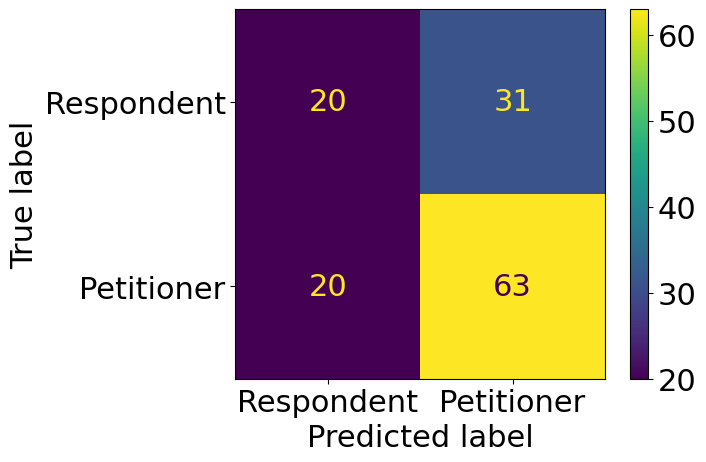

In [ ]:
# Grid Seach CV (cross validation)
# for regularization (lambda) C

param_grid = {'C': [0.0001, .001, .01, .1, 1, 5, 10, 25, 50]}


est = LogisticRegression(random_state=42, max_iter=5000)
clf = GridSearchCV(estimator=est, cv=5, param_grid=param_grid, refit=True)
clf = clf.fit(X_train_ros, torch.ravel(y_train_ros))

results = clf.cv_results_
best_run = np.argmax(results['mean_test_score'])
best_params = results['params'][best_run]
print(f'\nBest hyperparameters: {best_params}')
    
# get best model
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test_lr)

pred1 = np.where(y_pred < 0.5, 'Respondent', 'Petitioner')
y_true = np.where(y_test_lr == 0, 'Respondent', 'Petitioner')
cm = confusion_matrix(y_true, pred1, labels=['Respondent', 'Petitioner'])
cmd = ConfusionMatrixDisplay(cm, display_labels=['Respondent', 'Petitioner'])
plt.rc('font', size = 22)
cmd.plot()

In [ ]:
# calculate accuracy
(y_pred == np.array(y_test_lr.squeeze())).mean()

0.6194029850746269

In [ ]:
# get classification report
target_names = ['Respondent', 'Petitioner']
print(classification_report(y_true, pred1, target_names=target_names))

              precision    recall  f1-score   support

  Respondent       0.67      0.76      0.71        83
  Petitioner       0.50      0.39      0.44        51

    accuracy                           0.62       134
   macro avg       0.59      0.58      0.58       134
weighted avg       0.61      0.62      0.61       134



## SVM


Best hyperparameters: {'C': 10}


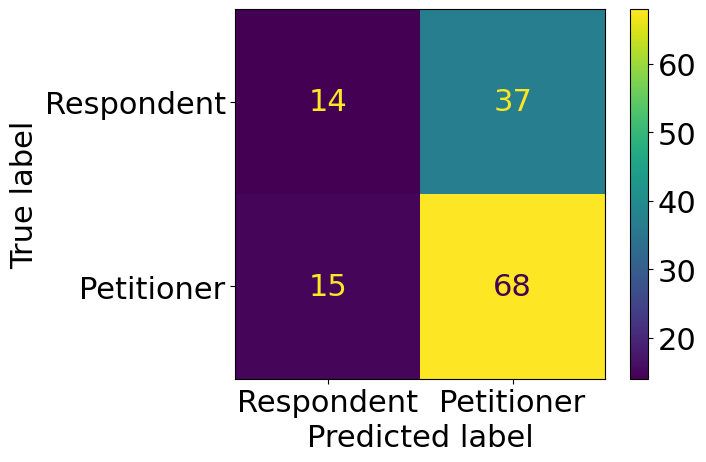

In [ ]:
# SVM Classifier

param_grid = {'C': [0.0001, .001, .01, .1, 1, 5, 10, 25, 50]}
est = SVC(random_state=42, max_iter=5000)
clf = GridSearchCV(estimator=est, cv=5, param_grid=param_grid, refit=True)
clf = clf.fit(X_train_ros, torch.ravel(y_train_ros))

results = clf.cv_results_
best_run = np.argmax(results['mean_test_score'])
best_params = results['params'][best_run]
print(f'\nBest hyperparameters: {best_params}')
    
# get best model
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test_lr)
pred1 = np.where(y_pred < 0.5, 'Respondent', 'Petitioner')
y_true = np.where(y_test_lr == 0, 'Respondent', 'Petitioner')
cm = confusion_matrix(y_true, pred1, labels=['Respondent', 'Petitioner'])
cmd = ConfusionMatrixDisplay(cm, display_labels=['Respondent', 'Petitioner'])
plt.rc('font', size = 22)
cmd.plot()

In [ ]:
# classification report
target_names = ['Respondent', 'Petitioner']
print(classification_report(y_true, pred1, target_names=target_names))

              precision    recall  f1-score   support

  Respondent       0.65      0.82      0.72        83
  Petitioner       0.48      0.27      0.35        51

    accuracy                           0.61       134
   macro avg       0.57      0.55      0.54       134
weighted avg       0.58      0.61      0.58       134



------

## Simple Neural Network

In [ ]:
# write the class

class NgramModel(nn.Module):
    def __init__(self, input_size, dropout, hidden_dim1, hidden_dim2, output_dim):
        super(NgramModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_dim1) 
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.nonlinear1 = nn.Tanh()
        self.nonlinear2 = nn.ReLU()
        # self.hidden_dim1 = hidden_dim1

    def forward(self, x):
        out = self.linear1(x)
        out = self.nonlinear1(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.nonlinear2(out)
        out = self.dropout(out)
        out = self.linear3(out)
        log_prob = F.log_softmax(out, dim=1)
        return log_prob


In [ ]:
# loss_function = torch.nn.MSELoss()
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.NLLLoss()

def train_an_epoch(dataloader):
    model.train() # Sets the module in training mode.
    log_interval = 20
    curr_loss = np.Inf

    for idx, (text, label) in enumerate(dataloader):
        label = label.squeeze().long() # for non mse loss fn
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [ ]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        prediction = []
        for idx, (word_idxs, label) in enumerate(dataloader):
            probs = model(word_idxs)
            total_acc += (probs.argmax(1) == label.squeeze()).sum().item()
            prediction.append(probs.argmax(1))
            total_count += word_idxs.size(0)

    return prediction, total_acc/total_count

In [ ]:
# Initialize model
model = NgramModel(input_size = input_matrix.shape[1],
                   dropout = 0.4, # previously 0.4
                   hidden_dim1 = 256,
                   hidden_dim2 = 128,
                   output_dim = 2) # either 1 or 0

In [ ]:
# train the model
EPOCHS = 15
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(train_dataloader)
    pred, accuracy = get_accuracy(val_dataloader)
    accuracies.append(accuracy)
    print(f'Epoch: {epoch}, validation accuracy: {accuracy:.3f}.')

At iteration 20 the loss is 0.674.
At iteration 40 the loss is 0.605.
At iteration 60 the loss is 0.663.
At iteration 80 the loss is 0.659.
Epoch: 1, validation accuracy: 0.478.
At iteration 20 the loss is 0.716.
At iteration 40 the loss is 0.644.
At iteration 60 the loss is 0.646.
At iteration 80 the loss is 0.585.
Epoch: 2, validation accuracy: 0.612.
At iteration 20 the loss is 0.645.
At iteration 40 the loss is 0.616.
At iteration 60 the loss is 0.549.
At iteration 80 the loss is 0.659.
Epoch: 3, validation accuracy: 0.567.
At iteration 20 the loss is 0.559.
At iteration 40 the loss is 0.619.
At iteration 60 the loss is 0.563.
At iteration 80 the loss is 0.504.
Epoch: 4, validation accuracy: 0.493.
At iteration 20 the loss is 0.532.
At iteration 40 the loss is 0.462.
At iteration 60 the loss is 0.523.
At iteration 80 the loss is 0.432.
Epoch: 5, validation accuracy: 0.657.
At iteration 20 the loss is 0.518.
At iteration 40 the loss is 0.443.
At iteration 60 the loss is 0.423.
At it

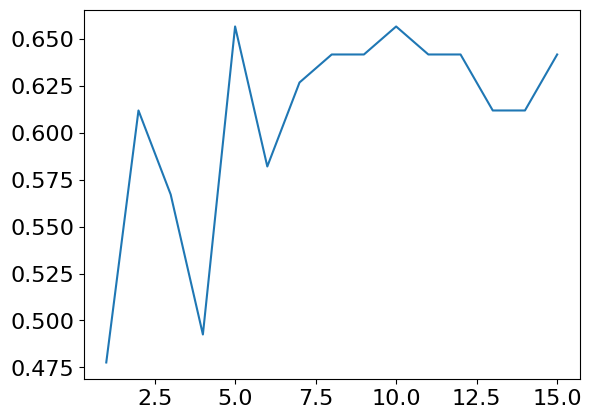

In [ ]:
# plot validation accuracy on epoch
plt.plot(range(1, EPOCHS+1), accuracies)
plt.rc('font', size = 16)
plt.savefig(PATH + 'NN.png', bbox_inches='tight')

In [ ]:
# test accuracy
def get_test_result(dataloader):
    model.eval()
    prediction = []
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        for idx, (word_idxs, label) in enumerate(dataloader):
            probs = model(word_idxs)
            total_acc += (probs.argmax(1) == label.squeeze()).sum().item()
            prediction.append(probs.argmax(1))
            total_count += word_idxs.size(0)
    accuracy = total_acc/total_count
    return prediction, accuracy

In [ ]:
# accuracy
pred, acc = get_test_result(test_dataloader) # unigrams
print(acc)
pred1 = torch.cat(pred).reshape(y_test.shape)

0.5373134328358209


In [ ]:
# classification report
target_names = ['Respondent', 'Petitioner']
print(classification_report(y_test, pred1, target_names=target_names))

              precision    recall  f1-score   support

  Respondent       0.61      0.35      0.45        31
  Petitioner       0.59      0.81      0.68        36

    accuracy                           0.60        67
   macro avg       0.60      0.58      0.57        67
weighted avg       0.60      0.60      0.57        67



## Tree-based models

### Boosted Trees

In [ ]:
# function to run gradient boosted tree w/ randomized search hyperparameter tuning
def find_best_params_run(X_train, y_train, X_test, y_test, param_grid, model):
    '''
    Uses RandomSearchCV to find best hyperparameters, uses best model to fit training data
    and then prints accuracy, precision & recall scores, confusion matrix and decision tree for
    easy visualization.
    
    Inputs:
        X_train, X_test (pandas DataFrames): train & test set features created from train/test split
            above
        y_train, y_test (pandas Series): train & test outcome variable ('foil_status') created from 
            train/test split above
        param_grid (dict): hyperparameters (keys) and potential values (values) for RandomizedSearchCV to tune
        model (str): either 'xgb' for XGBoost or any string for LightGBM model
        
    Returns: nothing
    '''
    if model == 'xgb':
        est = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

    else:
        est = lgb.LGBMClassifier(objective='binary')
        
    clf = RandomizedSearchCV(estimator=est, cv=5, param_distributions=param_grid, n_jobs=-1, verbose=-1,  refit=True)
    
    clf = clf.fit(X_train, y_train)

    results = clf.cv_results_
    
    best_run = np.argmax(results['mean_test_score'])
    best_params = results['params'][best_run]
    
    print(f'\nBest params: {best_params}')
    
    # get best model from CV
    best_model = clf.best_estimator_
    
    # prediction
    y_pred = best_model.predict(X_test)
    
    # create confusion matrix
    pred1 = np.where(y_pred == 0, 'Respondent', 'Petitioner')
    y_true = np.where(y_test == 0, 'Respondent', 'Petitioner')
    cm = confusion_matrix(y_true, pred1, labels=['Respondent', 'Petitioner'])
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Respondent', 'Petitioner'])
    plt.rc('font', size = 22)
    cmd.plot()

    # Evaluate using the accuracy
    print(f"\nCorrect Prediction Rate = {(y_true == pred1).mean():.4f}")
    print(f"Precision = {precision_score(y_true, pred1, pos_label = 'Petitioner'):.4f}")
    print(f"Recall = {recall_score(y_true, pred1, pos_label = 'Petitioner'):.4f}")

    target_names = ['Respondent', 'Petitioner']
    print(classification_report(y_true, pred1, target_names=target_names))


In [ ]:
# run xgboost -- takes too long
# param_grid_xg = {'gamma': [0, 1, 10, 50, 100],
#               'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5],
#               'max_depth': [3, 6, 10],
#               'min_child_weight': [0.01, 0.1, 0.5, 1, 5, 10],
#               'n_estimators': [50, 100, 150],
#               'reg_alpha': [0,0.1,0.5,1,10,50,100],
#               'reg_lambda': [0,0.1,0.5,1,10,50,100]}

# find_best_params_run(X_train_ros, torch.ravel(y_train_ros), X_test, y_test, param_grid_xg, 'xgb')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/usr/local/


Best params: {'reg_lambda': 0.001, 'reg_alpha': 10, 'num_leaves': 75, 'max_depth': 30, 'learning_rate': 0.5, 'boosting_type': 'rf'}

Correct Prediction Rate = 0.5570
Precision = 0.6263
Recall = 0.7470
              precision    recall  f1-score   support

  Respondent       0.63      0.75      0.68        83
  Petitioner       0.40      0.27      0.33        51

    accuracy                           0.57       134
   macro avg       0.51      0.51      0.50       134
weighted avg       0.54      0.57      0.55       134



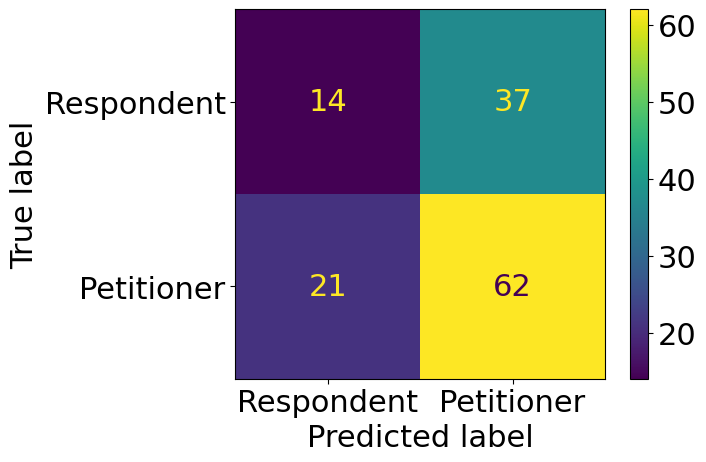

In [ ]:
# run lightgbm
param_grid_lgbm = {'boosting_type': ['gbdt', 'dart', 'rf'],
                'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5],
              'num_leaves': [10, 25, 50, 75, 100],
              'max_depth': [15, 30, 45, 60, 75, 90, 100],
              'reg_alpha': [0.001, .01, 0.1,0.5,1,10,50,100],
              'reg_lambda': [0.001, 0.01, 0.1,0.5,1,10,50,100]}

find_best_params_run(X_train_ros, torch.ravel(y_train_ros), X_test_lr, y_test_lr, param_grid_lgbm, 'lgbm')

### Random Forest 



Best params: {'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 50, 'bootstrap': True}


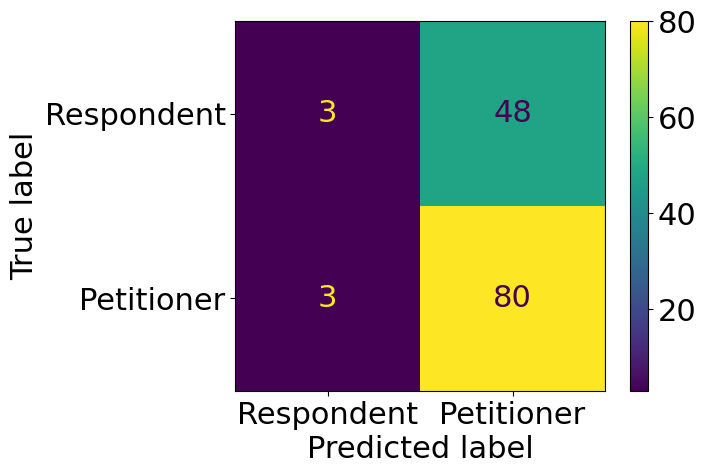

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid_rf = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

        
est = RandomForestClassifier(random_state=0)

clf = RandomizedSearchCV(estimator=est, cv=5, param_distributions=param_grid_rf, refit=True)
clf = clf.fit(X_train_ros, torch.ravel(y_train_ros))
# y_pred = clf.predict(X_test)
results = clf.cv_results_
best_run = np.argmax(results['mean_test_score'])
best_params = results['params'][best_run]
print(f'\nBest params: {best_params}')
    
# get best model
best_model = clf.best_estimator_
y_pred = best_model.predict(X_test_lr)

    # confusion matrix
pred1 = np.where(y_pred == 0, 'Respondent', 'Petitioner')
y_true = np.where(y_test_lr == 0, 'Respondent', 'Petitioner')
cm = confusion_matrix(y_true, pred1, labels=['Respondent', 'Petitioner'])
cmd = ConfusionMatrixDisplay(cm, display_labels=['Respondent', 'Petitioner'])
plt.rc('font', size = 22)
cmd.plot()

# # Evaluate using the accuracy
# print(f"\nCorrect Prediction Rate = {(y_true == pred1).mean():.4f}")
# print(f"Precision = {precision_score(y_true, pred1, pos_label = 'Petitioner'):.4f}")
# print(f"Recall = {recall_score(y_true, pred1, pos_label = 'Petitioner'):.4f}")
    

In [ ]:
# classification report
target_names = ['Respondent', 'Petitioner']
print(classification_report(y_true, pred1, target_names=target_names))

              precision    recall  f1-score   support

  Respondent       0.62      0.96      0.76        83
  Petitioner       0.50      0.06      0.11        51

    accuracy                           0.62       134
   macro avg       0.56      0.51      0.43       134
weighted avg       0.58      0.62      0.51       134

